In [1]:
import numpy as np
import glob as glob
import pprint
### Use the Glob Glob file slicing to get all the info from the file.

files = sorted(glob.glob('*fits'))
file_distance = []


### This Dummy Dictionary Stores information relating 
### GRAIN/D2G/MASS with distance and filename. 
dummy_dict = {
    "Wavelength" : [],
    "Grain" : [],
    "D2G" : [],
    "Mass" : [],
    "Planet Distance" : [],
    "Full File Name" : []
}    
### Opens the file
with open('distance_output.file') as f:
    ### Reads the file
    distance = f.readlines()
    
for i in range(int(len(distance))):
    if i % 2 == 0:
        file_name = distance[i].strip()
        au = distance[i+1].strip()   

        splitsies = file_name.split('-')
        
        dummy_dict['Grain'].append(splitsies[0].replace('GRAIN',''))
        dummy_dict['D2G'].append(splitsies[1].replace('D2G',''))
        dummy_dict['Mass'].append(splitsies[2].replace('MASS',''))
        dummy_dict['Planet Distance'].append(au)
        dummy_dict['Full File Name'].append(file_name)
###
        
        
### This is the real dictionary maker. 
### By real I mean it slices out all information for a file
### and stores it with the file name. 
file_dict = {
    "Wavelength" : [],
    "Grain" : [],
    "D2G" : [],
    "Mass" : [],
    "Planet Distance" : [],
    "Full File Name" : []
}    

for i in range(len(files)):
    splitsies = files[i].split('-')
    file_dict['Wavelength'].append(splitsies[0])
    file_dict['Grain'].append(splitsies[1].replace('GRAIN',''))
    file_dict['D2G'].append(splitsies[2].replace('D2G',''))
    file_dict['Mass'].append(splitsies[3].replace('MASS','').replace('.fits',''))
    file_dict['Planet Distance'].append(None)
    file_dict['Full File Name'].append(files[i])
###
    
    
### This takaes the dictionary of distances and associates it
### With the dictionary of file names 
for j in range(len(dummy_dict['D2G'])):
    for i in range(len(file_dict['D2G'])):
        ### Gets the pairs of file_name and distance   
        if file_dict['Grain'][i] == dummy_dict['Grain'][j] and file_dict['D2G'][i] == dummy_dict['D2G'][j]:
            file_dict['Planet Distance'][i] = dummy_dict['Planet Distance'][j]
            


In [2]:
import os
import glob
import numpy as np
import astropy.io as astr
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from matplotlib.ticker import AutoMinorLocator

def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)
    
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    
    
    
    return radialprofile 

def plot_fits(file_dict, verbose = True, selection = None, logSpace=True, radiusScale=False,  lBoundary=0, uBoundary=150):
    """
    INPUTS:
    --------
     
    
    
    OUTPUTS:
    --------
    
    
    """
    if selection == None:
        print("What in the fuck are you doing? \nThere aint no dictionary iterating.")
        return
    
    print('Log Space? {}'.format(logSpace))
    print('Scaled with Radius? {}'.format(radiusScale))    
    
    plt.figure()
    ### Extracting relevant info from fits file with astropy.fits
    wavelength = file_dict['Wavelength'][selection]
    grain = file_dict['Grain'][selection]
    d2g = file_dict['D2G'][selection]
    mass = file_dict['Mass'][selection]
    filename = file_dict['Full File Name'][selection]
    planet_locale = file_dict['Planet Distance'][selection]
    
    hdul = get_pkg_data_filename(filename)
    image_data = astr.fits.getdata(hdul, ext=0)
    data = image_data[0][0][0][:][:]
        
        ### Need to define the center for the radial profile
    center = (data.shape[0]/2,data.shape[1]/2)
    profile = radial_profile(data, center)
        
        ### This becomes the x-axis
    length = np.arange(profile.shape[0])
        
        ### Cuttomg down profile to Upper and Lower Boundary
    mod_profile = profile[lBoundary:uBoundary]
    normalized_profile = mod_profile/mod_profile.max()
        
    ### This ensures that even when truncated, x-axis is labeled correctly
        ### I have no recollection of what this is intended to do 12-18-2022
        ### Well I have no idea what it is indended to do, but I know what it does
    ### This scales the length array so that it isn't just an array along one dimension
    r_scale = center[0]/profile.shape[0]

    if logSpace == True:
        intensity_profile = np.log(normalized_profile)
            
    else:
        intensity_profile = normalized_profile
        
    if radiusScale == True:
        r_squared = length[lBoundary:uBoundary] ** 2
        intensity_profile = normalized_profile * r_squared
    
    title = "Grain Size : {grain} // D2G : {d2g}"
    label = title.format(grain = grain, d2g = d2g)
    picture = "{wavelength}-{grain}-{d2g}-{mass}.png"
    picture_name = picture.format(wavelength = wavelength,
                                 grain = grain,
                                 d2g = d2g,
                                 mass = mass)
    
    plt.vlines(float(planet_locale), intensity_profile.min(),intensity_profile.max(),color='r')
    plt.plot(length[lBoundary:uBoundary] * r_scale, intensity_profile,label=label)
    
    
    plt.tick_params(which='both', width=2)
    plt.tick_params(which='major', length=7)
    plt.tick_params(which='minor', length=4, color='r')
    plt.grid()
    plt.xlabel('AU')
    plt.ylabel('Normalized Intensity')
    plt.grid(which="minor")
    plt.legend()
    plt.savefig(picture_name)
    if verbose == True: 
        plt.show()

In [3]:
D2G0_005_dict = {
    "Wavelength" : [],
    "Grain" : [],
    "D2G" : [],
    "Mass" : [],
    "Planet Distance" : [],
    "Full File Name" : []
}

for i in range(len(files)):
    if file_dict['D2G'][i] == '0.005':
        D2G0_005_dict['Wavelength'].append(file_dict['Wavelength'][i])
        D2G0_005_dict['Grain'].append(file_dict['Grain'][i])
        D2G0_005_dict['D2G'].append(file_dict['D2G'][i])
        D2G0_005_dict['Mass'].append(file_dict['Mass'][i])
        D2G0_005_dict['Planet Distance'].append(file_dict['Planet Distance'][i])
        D2G0_005_dict['Full File Name'].append(file_dict['Full File Name'][i])
        
D2G0_01_dict = {
    "Wavelength" : [],
    "Grain" : [],
    "D2G" : [],
    "Mass" : [],
    "Planet Distance" : [],
    "Full File Name" : []
}

for i in range(len(files)):
    if file_dict['D2G'][i] == '0.01':
        D2G0_01_dict['Wavelength'].append(file_dict['Wavelength'][i])
        D2G0_01_dict['Grain'].append(file_dict['Grain'][i])
        D2G0_01_dict['D2G'].append(file_dict['D2G'][i])
        D2G0_01_dict['Mass'].append(file_dict['Mass'][i])
        D2G0_01_dict['Planet Distance'].append(file_dict['Planet Distance'][i])
        D2G0_01_dict['Full File Name'].append(file_dict['Full File Name'][i])

D2G0_05_dict = {
    "Wavelength" : [],
    "Grain" : [],
    "D2G" : [],
    "Mass" : [],
    "Planet Distance" : [],
    "Full File Name" : []
}

for i in range(len(files)):
    if file_dict['D2G'][i] == '0.05':
        D2G0_05_dict['Wavelength'].append(file_dict['Wavelength'][i])
        D2G0_05_dict['Grain'].append(file_dict['Grain'][i])
        D2G0_05_dict['D2G'].append(file_dict['D2G'][i])
        D2G0_05_dict['Mass'].append(file_dict['Mass'][i])
        D2G0_05_dict['Planet Distance'].append(file_dict['Planet Distance'][i])
        D2G0_05_dict['Full File Name'].append(file_dict['Full File Name'][i])

D2G0_10_dict = {
    "Wavelength" : [],
    "Grain" : [],
    "D2G" : [],
    "Mass" : [],
    "Planet Distance" : [],
    "Full File Name" : []
}

for i in range(len(files)):
    if file_dict['D2G'][i] == '0.10':
        D2G0_10_dict['Wavelength'].append(file_dict['Wavelength'][i])
        D2G0_10_dict['Grain'].append(file_dict['Grain'][i])
        D2G0_10_dict['D2G'].append(file_dict['D2G'][i])
        D2G0_10_dict['Mass'].append(file_dict['Mass'][i])
        D2G0_10_dict['Planet Distance'].append(file_dict['Planet Distance'][i])
        D2G0_10_dict['Full File Name'].append(file_dict['Full File Name'][i])
        
D2G0_5_dict = {
    "Wavelength" : [],
    "Grain" : [],
    "D2G" : [],
    "Mass" : [],
    "Planet Distance" : [],
    "Full File Name" : []
}

for i in range(len(files)):
    if file_dict['D2G'][i] == '0.5':
        D2G0_5_dict['Wavelength'].append(file_dict['Wavelength'][i])
        D2G0_5_dict['Grain'].append(file_dict['Grain'][i])
        D2G0_5_dict['D2G'].append(file_dict['D2G'][i])
        D2G0_5_dict['Mass'].append(file_dict['Mass'][i])
        D2G0_5_dict['Planet Distance'].append(file_dict['Planet Distance'][i])
        D2G0_5_dict['Full File Name'].append(file_dict['Full File Name'][i])

In [4]:
logSpace = True
radiusScale = False
### This controls the wavelength plotted
selection1 = 6
selection2 = 9
lBoundary=5  
uBoundary=150

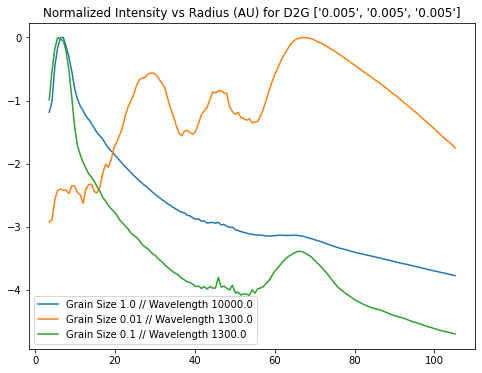

In [13]:
logSpace = True
### D2G 0.005
wavelength = D2G0_005_dict['Wavelength'][selection1:selection2]
grain = D2G0_005_dict['Grain'][selection1:selection2]
d2g = D2G0_005_dict['D2G'][selection1:selection2]
mass = D2G0_005_dict['Mass'][selection1:selection2]
filename = D2G0_005_dict['Full File Name'][selection1:selection2]
planet_locale = D2G0_005_dict['Planet Distance'][selection1:selection2]

figure, ax = plt.subplots(figsize=(8, 6))
for i in range(len(filename)):
    
    hdul = get_pkg_data_filename(filename[i])
    image_data = astr.fits.getdata(hdul, ext=0)
    data = image_data[0][0][0][:][:]
        
        ### Need to define the center for the radial profile
    center = (data.shape[0]/2,data.shape[1]/2)
    profile = radial_profile(data, center)
        
        ### This becomes the x-axis
    length = np.arange(profile.shape[0])
        
        ### Cuttomg down profile to Upper and Lower Boundary
    mod_profile = profile[lBoundary:uBoundary]
    normalized_profile = mod_profile/mod_profile.max()
        
    ### This ensures that even when truncated, x-axis is labeled correctly
        ### I have no recollection of what this is intended to do 12-18-2022
        ### Well I have no idea what it is indended to do, but I know what it does
    ### This scales the length array so that it isn't just an array along one dimension
    r_scale = center[0]/profile.shape[0]

    if logSpace == True:
        intensity_profile = np.log(normalized_profile)
            
    else:
        intensity_profile = normalized_profile
        
    if radiusScale == True:
        r_squared = length[lBoundary:uBoundary] ** 2
        intensity_profile = normalized_profile * r_squared
    
    
    #plt.vlines(float(planet_locale[i]), intensity_profile.min(),intensity_profile.max(),color='r')
    plt.title("Normalized Intensity vs Radius (AU) for D2G {d2g}".format(d2g=d2g))
    plt.plot(length[lBoundary:uBoundary] * r_scale, intensity_profile,
             label='Grain Size {} // Wavelength {}'.format(grain[i],wavelength[i]))
    plt.legend()
plt.show()    

In [19]:
### D2G 0.01
selection1 -=1
selection2 -=1
wavelength = D2G0_01_dict['Wavelength'][selection1:selection2]
grain = D2G0_01_dict['Grain'][selection1:selection2]
d2g = D2G0_01_dict['D2G'][selection1:selection2]
mass = D2G0_01_dict['Mass'][selection1:selection2]
filename = D2G0_01_dict['Full File Name'][selection1:selection2]
planet_locale = D2G0_01_dict['Planet Distance'][selection1:selection2]

#figure, ax = plt.subplots(figsize=(8, 6))
for i in range(len(filename)):
    
    hdul = get_pkg_data_filename(filename[i])
    image_data = astr.fits.getdata(hdul, ext=0)
    data = image_data[0][0][0][:][:]
    print(filename[i])
        ### Need to define the center for the radial profile
    center = (data.shape[0]/2,data.shape[1]/2)
    profile = radial_profile(data, center)
        
        ### This becomes the x-axis
    length = np.arange(profile.shape[0])
        
        ### Cuttomg down profile to Upper and Lower Boundary
    mod_profile = profile[lBoundary:uBoundary]
    normalized_profile = mod_profile/mod_profile.max()
        
    ### This ensures that even when truncated, x-axis is labeled correctly
        ### I have no recollection of what this is intended to do 12-18-2022
        ### Well I have no idea what it is indended to do, but I know what it does
    ### This scales the length array so that it isn't just an array along one dimension
    r_scale = center[0]/profile.shape[0]

    if logSpace == True:
        intensity_profile = np.log(normalized_profile)
            
    else:
        intensity_profile = normalized_profile
        
    if radiusScale == True:
        r_squared = length[lBoundary:uBoundary] ** 2
        intensity_profile = normalized_profile * r_squared
    
    #plt.vlines(float(planet_locale[i]), intensity_profile.min(),intensity_profile.max(),color='r')
    #plt.title("Normalized Intensity vs Radius (AU) for D2G {d2g}".format(d2g=d2g))
    #plt.plot(length[lBoundary:uBoundary] * r_scale, intensity_profile,
             #label='Grain Size {} // Wavelength {}'.format(grain[i],wavelength[i]))
    #plt.legend()
#plt.show()    

1000.0-GRAIN0.01-D2G0.01-MASS0.0101.fits
1000.0-GRAIN0.1-D2G0.01-MASS0.0101.fits
1000.0-GRAIN1.0-D2G0.01-MASS0.0101.fits


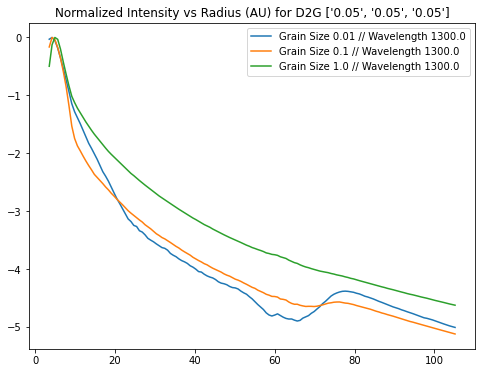

In [7]:
### D2G 0.05
wavelength = D2G0_05_dict['Wavelength'][selection1:selection2]
grain = D2G0_05_dict['Grain'][selection1:selection2]
d2g = D2G0_05_dict['D2G'][selection1:selection2]
mass = D2G0_05_dict['Mass'][selection1:selection2]
filename = D2G0_05_dict['Full File Name'][selection1:selection2]
planet_locale = D2G0_05_dict['Planet Distance'][selection1:selection2]

figure, ax = plt.subplots(figsize=(8, 6))
for i in range(len(filename)):
    
    hdul = get_pkg_data_filename(filename[i])
    image_data = astr.fits.getdata(hdul, ext=0)
    data = image_data[0][0][0][:][:]
        
        ### Need to define the center for the radial profile
    center = (data.shape[0]/2,data.shape[1]/2)
    profile = radial_profile(data, center)
        
        ### This becomes the x-axis
    length = np.arange(profile.shape[0])
        
        ### Cuttomg down profile to Upper and Lower Boundary
    mod_profile = profile[lBoundary:uBoundary]
    normalized_profile = mod_profile/mod_profile.max()
        
    ### This ensures that even when truncated, x-axis is labeled correctly
        ### I have no recollection of what this is intended to do 12-18-2022
        ### Well I have no idea what it is indended to do, but I know what it does
    ### This scales the length array so that it isn't just an array along one dimension
    r_scale = center[0]/profile.shape[0]

    if logSpace == True:
        intensity_profile = np.log(normalized_profile)
            
    else:
        intensity_profile = normalized_profile
        
    if radiusScale == True:
        r_squared = length[lBoundary:uBoundary] ** 2
        intensity_profile = normalized_profile * r_squared
    
    plt.title("Normalized Intensity vs Radius (AU) for D2G {d2g}".format(d2g=d2g))
    plt.plot(length[lBoundary:uBoundary] * r_scale, intensity_profile,
             label='Grain Size {} // Wavelength {}'.format(grain[i],wavelength[i]))
    plt.legend()
plt.show()    

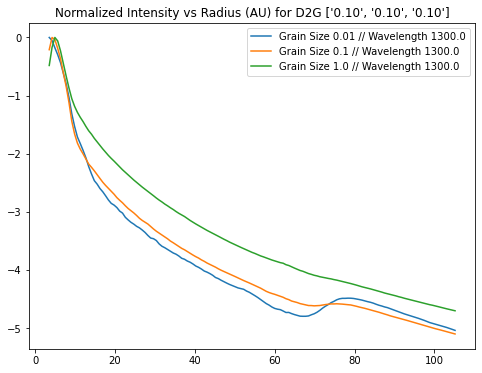

In [8]:
### D2G 0.10
wavelength = D2G0_10_dict['Wavelength'][selection1:selection2]
grain = D2G0_10_dict['Grain'][selection1:selection2]
d2g = D2G0_10_dict['D2G'][selection1:selection2]
mass = D2G0_10_dict['Mass'][selection1:selection2]
filename = D2G0_10_dict['Full File Name'][selection1:selection2]
planet_locale = D2G0_10_dict['Planet Distance'][selection1:selection2]

figure, ax = plt.subplots(figsize=(8, 6))
for i in range(len(filename)):
    
    hdul = get_pkg_data_filename(filename[i])
    image_data = astr.fits.getdata(hdul, ext=0)
    data = image_data[0][0][0][:][:]
        
        ### Need to define the center for the radial profile
    center = (data.shape[0]/2,data.shape[1]/2)
    profile = radial_profile(data, center)
        
        ### This becomes the x-axis
    length = np.arange(profile.shape[0])
        
        ### Cuttomg down profile to Upper and Lower Boundary
    mod_profile = profile[lBoundary:uBoundary]
    normalized_profile = mod_profile/mod_profile.max()
        
    ### This ensures that even when truncated, x-axis is labeled correctly
        ### I have no recollection of what this is intended to do 12-18-2022
        ### Well I have no idea what it is indended to do, but I know what it does
    ### This scales the length array so that it isn't just an array along one dimension
    r_scale = center[0]/profile.shape[0]

    if logSpace == True:
        intensity_profile = np.log(normalized_profile)
            
    else:
        intensity_profile = normalized_profile
        
    if radiusScale == True:
        r_squared = length[lBoundary:uBoundary] ** 2
        intensity_profile = normalized_profile * r_squared
    
    plt.title("Normalized Intensity vs Radius (AU) for D2G {d2g}".format(d2g=d2g))
    plt.plot(length[lBoundary:uBoundary] * r_scale, intensity_profile,
             label='Grain Size {} // Wavelength {}'.format(grain[i],wavelength[i]))
    plt.legend()
plt.show()    

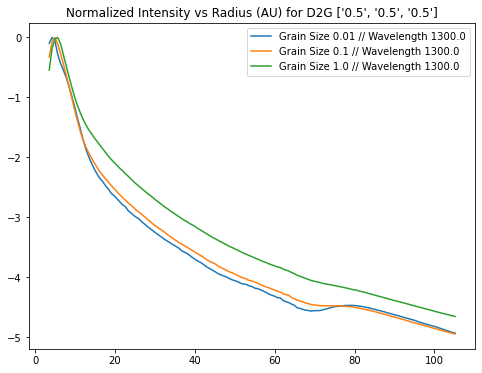

In [9]:
### D2G 0.50
wavelength = D2G0_5_dict['Wavelength'][selection1:selection2]
grain = D2G0_5_dict['Grain'][selection1:selection2]
d2g = D2G0_5_dict['D2G'][selection1:selection2]
mass = D2G0_5_dict['Mass'][selection1:selection2]
filename = D2G0_5_dict['Full File Name'][selection1:selection2]
planet_locale = D2G0_5_dict['Planet Distance'][selection1:selection2]

figure, ax = plt.subplots(figsize=(8, 6))
for i in range(len(filename)):
    
    hdul = get_pkg_data_filename(filename[i])
    image_data = astr.fits.getdata(hdul, ext=0)
    data = image_data[0][0][0][:][:]
        
        ### Need to define the center for the radial profile
    center = (data.shape[0]/2,data.shape[1]/2)
    profile = radial_profile(data, center)
        
        ### This becomes the x-axis
    length = np.arange(profile.shape[0])
        
        ### Cuttomg down profile to Upper and Lower Boundary
    mod_profile = profile[lBoundary:uBoundary]
    normalized_profile = mod_profile/mod_profile.max()
        
    ### This ensures that even when truncated, x-axis is labeled correctly
        ### I have no recollection of what this is intended to do 12-18-2022
        ### Well I have no idea what it is indended to do, but I know what it does
    ### This scales the length array so that it isn't just an array along one dimension
    r_scale = center[0]/profile.shape[0]

    if logSpace == True:
        intensity_profile = np.log(normalized_profile)
            
    else:
        intensity_profile = normalized_profile
        
    if radiusScale == True:
        r_squared = length[lBoundary:uBoundary] ** 2
        intensity_profile = normalized_profile * r_squared
    
    plt.title("Normalized Intensity vs Radius (AU) for D2G {d2g}".format(d2g=d2g))
    plt.plot(length[lBoundary:uBoundary] * r_scale, intensity_profile,
             label='Grain Size {} // Wavelength {}'.format(grain[i],wavelength[i]))
    plt.legend()
plt.show()    